<a href="https://colab.research.google.com/github/js081194/thesis2024/blob/main/Stacked_Image_w_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import pprint as pp
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn as sns

ee.Authenticate()
ee.Initialize(project='jayathesis0811')

In [2]:
north_korea_coords = [[[124.13253718384772, 40.21335053920326],
                       [129.949853918996, 43.061730142931324],
                       [130.78322983865831, 42.22804007650052],
                       [128.2987669179184, 38.5948400683505],
                       [125.31524149369977, 37.69040330384843]]]

north_korea_geometry1 = ee.Geometry.Polygon(north_korea_coords)

KyoHwaSo_coords = [[[129.8634297005607, 42.893827126434914],
                    [130.51078146306347, 42.438049492565],
                    [129.67576441706638, 41.06180325052066],
                    [128.7824903707054, 41.987391837758274]]]

KyoHwaSo = ee.Geometry.Polygon(KyoHwaSo_coords)

In [3]:
#import prison coordinate file
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

file_path = '/content/drive/My Drive/Prison locations - Sheet1.csv'

df = pd.read_csv(file_path)

print(df)

Mounted at /content/drive
       Location name    Latitude   Longitude
0             Camp 22  42.741872  129.861829
1  Chongori (camp 12)  42.300577  129.740979
2             HamHung  40.084117  127.595666
3               Yodok  39.893609  126.873364
4            KangDong  39.081040  126.153259
5             KaeChon  39.571369  126.055604
6         KaeChon 2nd  39.708340  125.923179
7           HyangHari  40.988123  126.655336
8             Sinuiju  40.061710  124.409505
9            PukChang  39.559812  126.088062


In [4]:
# Creating an empty Earth Engine feature collection
features = []

for i, (_, row) in enumerate(df.iterrows(), start=1):
    lat, lon = row['Latitude'], row['Longitude']

    point = ee.Geometry.Point(lon, lat)

    feature = ee.Feature(point, {'index': i})

    features.append(feature)

feature_collection = ee.FeatureCollection(features)

Map = geemap.Map()
Map.setCenter(129.5, 42.0, 10)
Map.addLayer(north_korea_geometry1, {}, 'region')
Map.addLayer(feature_collection, {'color': 'red'}, 'Markers')
Map.addLayerControl()
Map

Map(center=[42.0, 129.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [6]:
# Land classification and masking
dataset = ee.ImageCollection('COPERNICUS/Landcover/100m/Proba-V-C3/Global')
classification = dataset.select('discrete_classification').min()

mask_shrub = classification.eq(20)
mask_hveg = classification.eq(30)
mask_cveg = classification.eq(40)
mask_bare = classification.eq(60)
mask_moss = classification.eq(100)
mask_forest = classification.eq(111)
mask_forest1 = classification.eq(112)
mask_forest2 = classification.eq(113)
mask_forest3 = classification.eq(114)
mask_forest4 = classification.eq(115)
mask_forest5 = classification.eq(116)
mask_forest6 = classification.eq(121)
mask_forest7 = classification.eq(122)
mask_forest8 = classification.eq(123)
mask_forest9 = classification.eq(124)
mask_forest10 = classification.eq(125)
mask_forest11 = classification.eq(126)
mask_all = mask_cveg.Or(mask_hveg).Or(mask_moss).Or(mask_bare).Or(mask_shrub).Or(mask_forest).Or(mask_forest1).Or(mask_forest2).Or(mask_forest3).Or(mask_forest4).Or(mask_forest5).Or(mask_forest6).Or(mask_forest7).Or(mask_forest8).Or(mask_forest9).Or(mask_forest10).Or(mask_forest11)

# Loading the L8 image collection, filtering by bounds, date, and cloud cover.
korea = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterBounds(north_korea_geometry1) \
    .filterDate('2019-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUD_COVER', 1)) \
    .min()

landsat_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10']
landsat = korea.select(landsat_bands)

# Loading air pollution datasets and calculate mean for date range.
UV_Aerosol = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_AER_AI") \
    .filterDate("2019-01-01", "2023-12-31") \
    .select('absorbing_aerosol_index') \
    .mean()

CO = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_CO") \
    .filterDate("2019-01-01", "2023-12-31") \
    .select('CO_column_number_density') \
    .mean()

NO = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterDate("2019-01-01", "2023-12-31") \
    .select('tropospheric_NO2_column_number_density') \
    .mean()

SO = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_SO2") \
    .filterDate("2019-01-01", "2023-12-31") \
    .select('SO2_column_number_density') \
    .mean()

elevation = ee.Image("CGIAR/SRTM90_V4").select('elevation')


# target scale and projection
target_scale = 100
target_crs = UV_Aerosol.projection()

landsat_resampled = landsat.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
UV_Aerosol_resampled = UV_Aerosol.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
CO_resampled = CO.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
NO_resampled = NO.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
SO_resampled = SO.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
elevation_resampled = elevation.resample('bilinear').reproject(crs=target_crs, scale=target_scale)

# mask each layer
landsat_masked = landsat_resampled.updateMask(mask_all)
UV_Aerosol_masked = UV_Aerosol_resampled.updateMask(mask_all)
CO_masked = CO_resampled.updateMask(mask_all)
NO_masked = NO_resampled.updateMask(mask_all)
SO_masked = SO_resampled.updateMask(mask_all)
elevation_masked = elevation_resampled.updateMask(mask_all)

# Combining masked layers into a stacked image
stacked_image = landsat_masked \
    .addBands(UV_Aerosol_masked) \
    .addBands(CO_masked) \
    .addBands(NO_masked) \
    .addBands(SO_masked) \
    .addBands(elevation_masked)

vis_params = {
    'UV_Aerosol': {'min': 0, 'max': 1, 'palette': ['blue', 'purple']},
    'CO': {'min': 0, 'max': 0.05, 'palette': ['green', 'yellow', 'red']},
    'NO': {'min': 0, 'max': 0.0002, 'palette': ['blue', 'green', 'red']},
    'SO': {'min': 0, 'max': 0.0001, 'palette': ['yellow', 'orange', 'red']},
    'elevation': {'min': 0, 'max': 3000, 'palette': ['blue', 'green', 'brown']}
}

stack_vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3, 'gamma': 1.4}


m = geemap.Map()
m.setCenter(127.5, 40, 6)
m.addLayer(elevation_masked.clip(north_korea_geometry1), vis_params['elevation'], 'Elevation')
m.addLayer(stacked_image.clip(north_korea_geometry1), stack_vis_params, 'Stacked Image')
m.addLayer(feature_collection, {'color': 'red'}, 'Markers')
m.addLayerControl()
m


Map(center=[40, 127.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

In [7]:
drive_folder_path = '/content/drive/My Drive/Heatmaps_Project/'

In [16]:
#k-means clustering
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'absorbing_aerosol_index', 'CO_column_number_density', 'tropospheric_NO2_column_number_density', 'SO2_column_number_density', 'elevation']

training = stacked_image.select(bands).sample(
    region=north_korea_geometry1,
    scale=100,  #matched to scale of layers in image
    numPixels=5000,
    seed=1,  # allows for reproducibility
    tileScale=4  # used for large regions to manage memory
)

trainedKMeans = ee.Clusterer.wekaKMeans(nClusters=100000).train(training)

result = stacked_image.cluster(trainedKMeans).clip(north_korea_geometry1)

Map = geemap.Map()
Map.setCenter(127.5, 40.0, 6)
Map.addLayer(result.randomVisualizer(), {}, 'Clusters')
Map.addLayer(feature_collection, {'color': 'red'}, 'Markers')
Map.addLayerControl()
Map


Map(center=[40.0, 127.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [17]:
#zoomed in maps for each prison location
def display_map_for_feature(feature):
    geometry = feature.geometry()
    centroid = geometry.centroid()

    # 10km buffer around the prison areas
    buffer = geometry.buffer(10000)

    Map = geemap.Map()
    Map.centerObject(centroid, 11)
    Map.addLayer(result.randomVisualizer(), {}, 'Clusters')
    Map.addLayer(ee.FeatureCollection([feature]), {'color': 'red'}, 'Marker')
    buffer_style = {
        'color': '000000',
        'width': 4,
        'fillColor': '00000000'
    }
    Map.addLayer(ee.FeatureCollection([buffer]).style(**buffer_style), {}, '5km Buffer')
    Map.addLayerControl()
    return Map

maps = []
for feature in feature_collection.getInfo()['features']:
    ee_feature = ee.Feature(feature)
    map_instance = display_map_for_feature(ee_feature)
    maps.append(map_instance)


In [18]:
for idx, map_instance in enumerate(maps):
    display(map_instance)
    print(f"Map {idx+1}")

Map(center=[42.74187239772032, 129.86182868888375], controls=(WidgetControl(options=['position', 'transparent_…

Map 1


Map(center=[42.30057680390256, 129.74097899954538], controls=(WidgetControl(options=['position', 'transparent_…

Map 2


Map(center=[40.08411680716855, 127.59566573931811], controls=(WidgetControl(options=['position', 'transparent_…

Map 3


Map(center=[39.89360857597686, 126.87336391189392], controls=(WidgetControl(options=['position', 'transparent_…

Map 4


Map(center=[39.08104017607688, 126.15325913150174], controls=(WidgetControl(options=['position', 'transparent_…

Map 5


Map(center=[39.5713690376952, 126.05560440329744], controls=(WidgetControl(options=['position', 'transparent_b…

Map 6


Map(center=[39.70834022048452, 125.92317915391428], controls=(WidgetControl(options=['position', 'transparent_…

Map 7


Map(center=[40.988123042260135, 126.6553364424719], controls=(WidgetControl(options=['position', 'transparent_…

Map 8


Map(center=[40.06171046531749, 124.40950493549113], controls=(WidgetControl(options=['position', 'transparent_…

Map 9


Map(center=[39.55981183732057, 126.08806233974532], controls=(WidgetControl(options=['position', 'transparent_…

Map 10


Clusters for Camp 22 (Location: 42.74187239772033, 129.86182868888375): {'130': 40, '1328': 46.423529411764704, '1350': 21.341176470588234, '1416': 1715.3098039215683, '1453': 3786.0156862745093, '1509': 5730, '1749': 442, '1903': 3721.0980392156857, '207': 4584.964705882353, '2357': 16.235294117647058, '2565': 22.392156862745097, '2614': 21, '265': 1123.2313725490196, '3': 535.0588235294116, '3314': 8480.329411764704, '3433': 316.63529411764705, '3617': 3190.423529411765, '3642': 332.2352941176471, '3644': 189.6862745098039, '3893': 962, '428': 333.1098039215685, '478': 190.95294117647063, '481': 2507.3137254901962, '522': 376.5254901960784, '545': 70.62745098039215, '626': 384.5450980392156, '818': 386.75294117647064, '990': 1914.698039215686}
Clusters for KyoHWaSo Camp 12 (Location: 42.30057680390256, 129.74097899954538): {'1006': 2180.933333333334, '121': 2008.0627450980392, '124': 1037.678431372549, '1366': 908.521568627451, '1524': 7194.0470588235285, '1539': 4.254901960784314, '

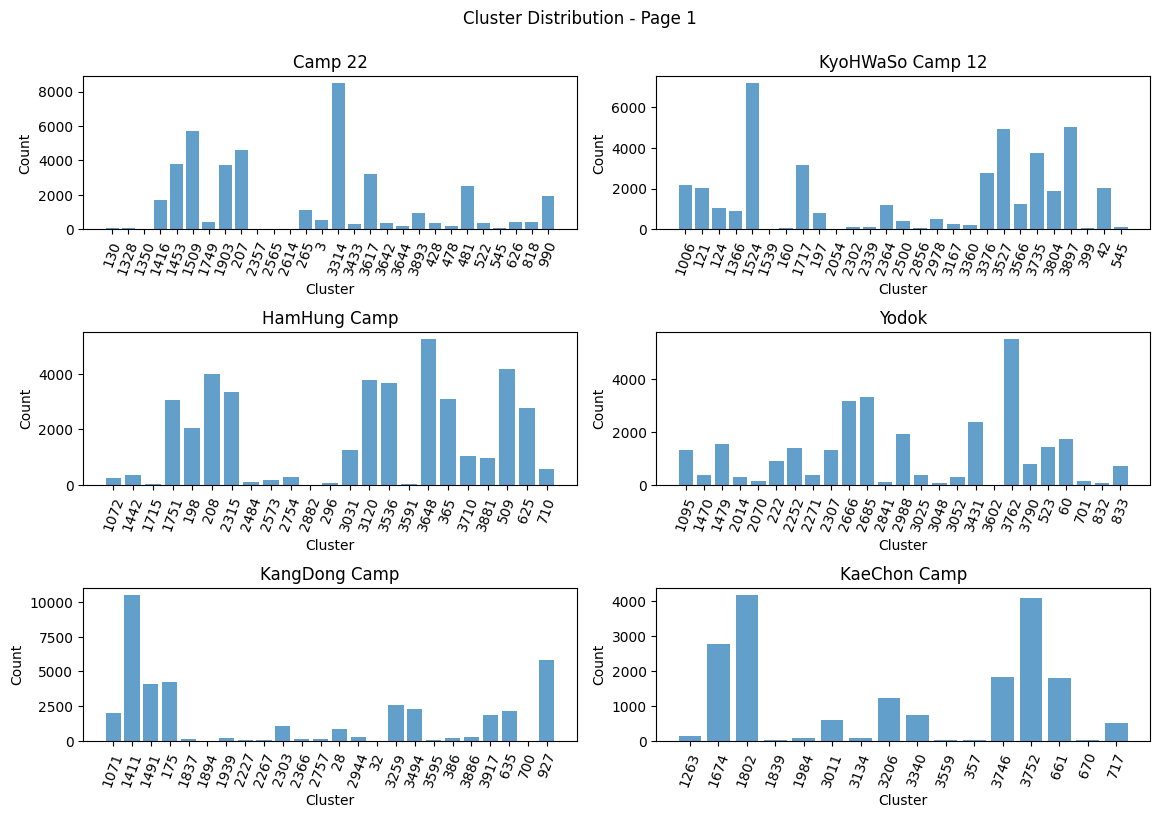

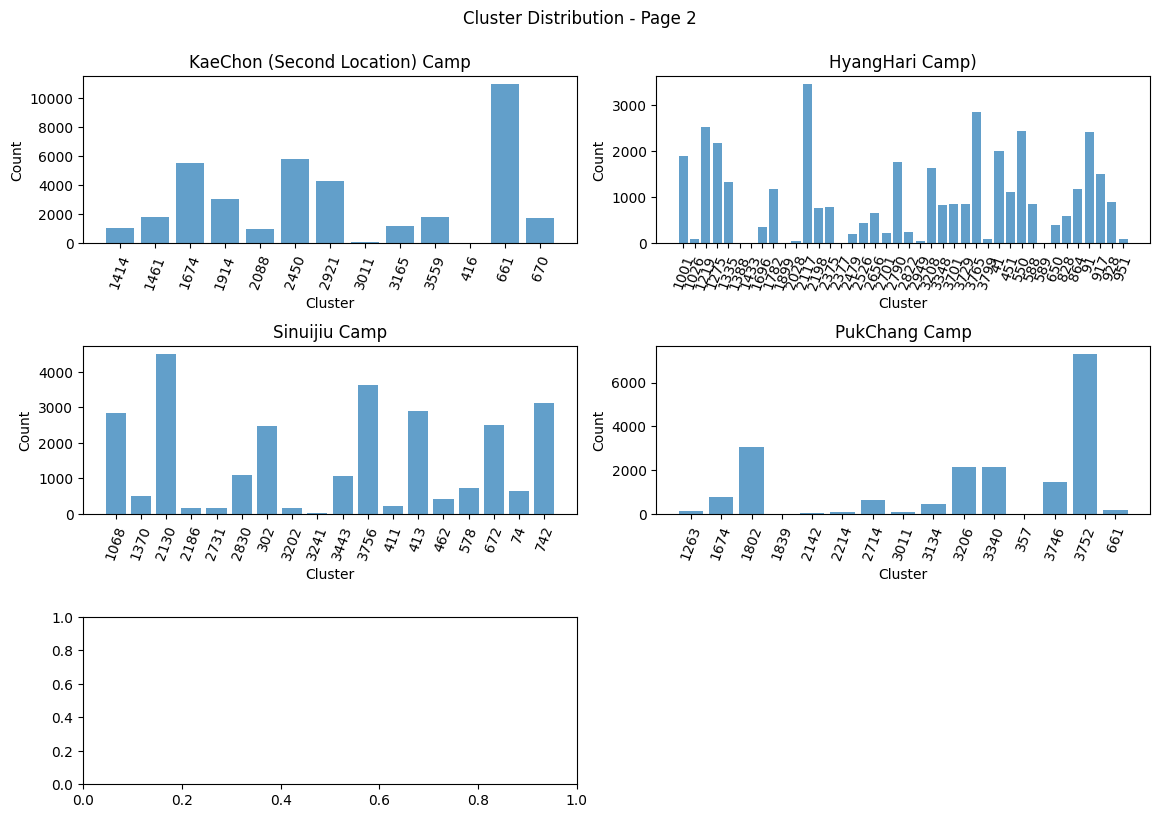

In [19]:
# cluster counts and  histograms
def extract_cluster_counts(image, locations, radius):
    cluster_counts = []
    for location in locations:
        marker_geom = ee.Geometry.Point([location['Longitude'], location['Latitude']])

        region = marker_geom.buffer(radius)

        clusters = image.reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=region,
            scale=100,
            maxPixels=1e13
        ).get('cluster').getInfo()

        print(f"Clusters for {location['Name']} (Location: {location['Latitude']}, {location['Longitude']}): {clusters}")

        cluster_counts.append(clusters)

    return cluster_counts

locations = [
    {'Latitude': 42.74187239772033, 'Longitude': 129.86182868888375, 'Name': 'Camp 22'},
    {'Latitude': 42.30057680390256, 'Longitude': 129.74097899954538, 'Name': 'KyoHWaSo Camp 12'},
    {'Latitude': 40.08411680716854, 'Longitude': 127.59566573931812, 'Name': 'HamHung Camp'},
    {'Latitude': 39.893608575976856, 'Longitude': 126.8733639118939, 'Name': 'Yodok'},
    {'Latitude': 39.08104017607688, 'Longitude': 126.15325913150171, 'Name': 'KangDong Camp'},
    {'Latitude': 39.5713690376952, 'Longitude': 126.05560440329742, 'Name': 'KaeChon Camp'},
    {'Latitude': 39.70834022048452, 'Longitude': 125.92317915391429, 'Name': 'KaeChon (Second Location) Camp'},
    {'Latitude': 40.988123042260135, 'Longitude': 126.6553364424719, 'Name': 'HyangHari Camp)'},
    {'Latitude': 40.06171046531748, 'Longitude': 124.40950493549113, 'Name': 'Sinuijiu Camp'},
    {'Latitude': 39.55981183732056, 'Longitude': 126.08806233974533, 'Name': 'PukChang Camp'},
]

radius = 10000  # 10km

cluster_counts = extract_cluster_counts(result, locations, radius)

def plot_histograms(cluster_counts, locations):
    rows_page1, cols_page1 = 3, 2
    rows_page2, cols_page2 = 3, 2

    fig1, axs1 = plt.subplots(rows_page1, cols_page1, figsize=(11.7, 8.3))
    fig1.suptitle('Cluster Distribution - Page 1')

    for i in range(6):
        clusters = cluster_counts[i]
        location_name = locations[i]['Name']
        ax = axs1[i // cols_page1, i % cols_page1]
        if clusters:
            data = {'Cluster': list(clusters.keys()), 'Count': list(clusters.values())}
            df = pd.DataFrame(data)
            df = df.sort_values(by='Cluster')

            ax.bar(df['Cluster'], df['Count'], alpha=0.7)
            ax.set_xlabel('Cluster')
            ax.set_ylabel('Count')
            ax.set_title(location_name)
            ax.tick_params(axis='x', rotation=70)
        else:
            ax.text(0.5, 0.5, 'No clusters found', horizontalalignment='center', verticalalignment='center')
            ax.set_title(location_name)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(drive_folder_path + 'Cluster_Distribution_P1.png', dpi=300)

    fig2, axs2 = plt.subplots(rows_page2, cols_page2, figsize=(11.7, 8.3))
    fig2.suptitle('Cluster Distribution - Page 2')

    for i in range(4):
        clusters = cluster_counts[i + 6]
        location_name = locations[i + 6]['Name']
        ax = axs2[i // cols_page2, i % cols_page2]
        if clusters:
            data = {'Cluster': list(clusters.keys()), 'Count': list(clusters.values())}
            df = pd.DataFrame(data)
            df = df.sort_values(by='Cluster')

            ax.bar(df['Cluster'], df['Count'], alpha=0.7)
            ax.set_xlabel('Cluster')
            ax.set_ylabel('Count')
            ax.set_title(location_name)
            ax.tick_params(axis='x', rotation=70)
        else:
            ax.text(0.5, 0.5, 'No clusters found', horizontalalignment='center', verticalalignment='center')
            ax.set_title(location_name)

    fig2.delaxes(axs2[2, 1])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(drive_folder_path + 'Cluster_Distribution_P2.png', dpi=300)

plot_histograms(cluster_counts, locations)
